In [1]:
%matplotlib inline


### Supervised Learning : Support Vector Machine 

Welcome to the "Supervised Learning : Support Vector Machine" practical session.  

Programming Language : Python 
Editor : Jupyter Notebook. 

Pandas : Data loading, processing, transformation and manipulation.
Scikit-learn : Example data source, ML and statistical analysis


In [4]:
# Import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt


#### Load relevant data and partition the data for train and test
Here we will use the same breast cancer data set.
After loading the data we will partition the data into train and test. 
In this example we will 80% data for training and remaining 20% will be left for testing. 

In [7]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(455, 30)
(114, 30)


## Hyper parameter tuning through grid search
The grid search process is employed to find the best hyperparameter for the Gaussian Naive Bayes model, specifically the 'var_smoothing' parameter.

- In the code block where we perform hyperparameter tuning, we are using the GridSearchCV function from sklearn. This function exhaustively tries all combinations of hyperparameter values from a specified grid, in order to find the values that give the best performance according to a specified scoring method.

- In this context, we are tuning the 'C' parameter of the linear SVM classifier. The 'C' parameter controls the trade-off between achieving a low training error and a low testing error that is, a trade-off between overfitting and underfitting. In simpler terms, 'C' is the penalty parameter of the error term. It controls the balance between smooth decision boundary and classifying training points correctly. A large 'C' creates a smaller-margin hyperplane and correctly classifies more training examples, which might lead to overfitting. On the other hand, a smaller 'C' will create a larger-margin hyperplane and might lead to underfitting.

- In the grid search, we use param_grid = {'C': np.logspace(-3, 3, 7)}, where np.logspace(-3, 3, 7) generates numbers that are evenly spaced on a log scale. Here, -3 and 3 are the powers of 10 that start and end the sequence, and 7 is the number of values to generate. Thus, the 'C' parameter values tried by the grid search will be [0.001, 0.01, 0.1, 1, 10, 100, 1000]. This wide range should help ensure that the grid search can find a good value for 'C', whether it needs to be small or large.

- After GridSearchCV is done, it will provide the best 'C' value found, which is then used to create an optimal SVM model. The model is then fit to the data, and its performance is evaluated.

In [8]:
# Setting up hyperparameters
param_grid = {'C': np.logspace(-3, 3, 7)}

print(param_grid)

{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}


In [6]:
# Setting up hyperparameters
param_grid = {'C': np.logspace(-3, 3, 7)}

# Use Linear SVM model
svc = svm.SVC(kernel='linear', probability=True)

# Use grid search for hyperparameters tuning
svc_cv = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
svc_cv.fit(X_train, y_train)

# Find out the best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

# Define the best Linear SVM model
svc_best = svm.SVC(kernel='linear', C=svc_cv.best_params_['C'], probability=True)


Best Parameters: {'C': 100.0}


### Model Training and Performance Evaluation via five-fold cross validation.

Five-fold cross-validation is used along with the Receiver Operating Characteristic (ROC) curve to validate the effectiveness of the Linear SVM model and its ability to classify the breast cancer dataset.

Here's a step-by-step explanation:

- Define the cross-validation strategy: cv = StratifiedKFold(n_splits=5). This line initiates the StratifiedKFold object, which is a cross-validator that provides train/test indices to split the data into train/test sets. The 'Stratified' part means that the folds are made by preserving the percentage of samples for each class.

- Initialize necessary lists and parameters: tprs = [], aucs = [], mean_fpr = np.linspace(0, 1, 100). These lines set up the necessary lists and parameters to store true positive rates (TPR), area under curve (AUC) scores, and the mean false positive rate (FPR).

- Iterate over each fold: for i, (train, val) in enumerate(cv.split(X_train, y_train)). This loop goes through each of the five splits of the data. For each split, it fits the model on the training data (svc_best.fit(X_train[train], y_train[train])) and generates a ROC curve. The TPR for each FPR is interpolated and stored, as is the AUC.

- Plot a baseline ROC curve: ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8). This line plots a diagonal line that represents a random classifier. This serves as a baseline to compare the SVM classifier against.

- Calculate mean TPR and AUC: mean_tpr = np.mean(tprs, axis=0), mean_auc = auc(mean_fpr, mean_tpr). These lines calculate the mean TPR and mean AUC, giving a sense of how well the model performs on average across the folds.

- Plot the mean ROC curve: ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8). The mean ROC curve shows the average TPR at each FPR, across all folds. This gives a visual representation of the model's performance.


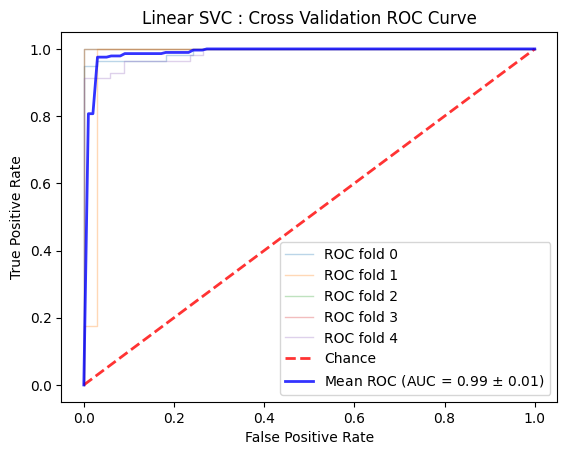

In [8]:
# ROC curve for each fold in cross validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    svc_best.fit(X_train[train], y_train[train])
    y_score = svc_best.predict_proba(X_train[val])[:, 1]
    fpr, tpr, _ = roc_curve(y_train[val], y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, alpha=0.3, lw=1, name='ROC fold {}'.format(i))
    interp_tpr = np.interp(mean_fpr, roc_display.fpr, roc_display.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

plt.title("Linear SVC : Cross Validation ROC Curve")
plt.legend(loc='best')
plt.show()


### Evaluate on test data: 

- Finally, we evaluate the performance of our trained model on the left out test dataset. After validating the model with cross-validation, it's finally evaluated on the test data, and the accuracy and ROC curve are displayed.

SVC Accuracy on test data:  0.9649122807017544


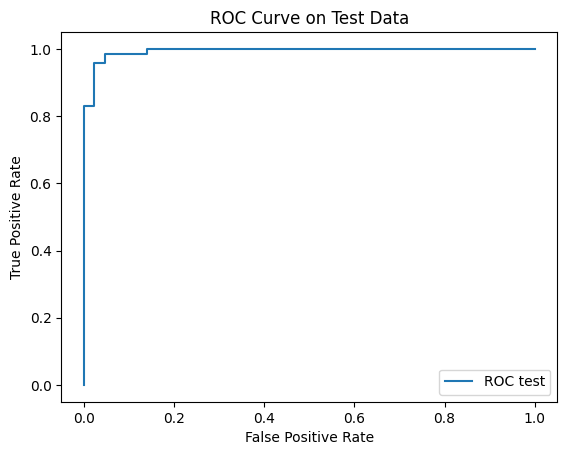

In [10]:
# Evaluate on test data
y_pred = svc_best.predict(X_test)
print("SVC Accuracy on test data: ", accuracy_score(y_test, y_pred))

# ROC curve for test data
y_score_test = svc_best.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
roc_display_test = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot(name='ROC test')
plt.title("ROC Curve on Test Data")
plt.show()


### Your Task

- For this practical you will use the Indian Liver Patient Dataset (lipid ) data set. 

This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from north east of Andhra Pradesh, India. The class label divides the patients into 2 groups (liver patient or not). This data set contains 441 male patient records and 142 female patient records.

Attribute Information
V1. Age of the patient. Any patient whose age exceeded 89 is listed as being of age "90".
V2. Gender of the patient
V3. Total Bilirubin
V4. Direct Bilirubin
V5. Alkphos Alkaline Phosphatase
V6. Sgpt Alanine Aminotransferase
V7. Sgot Aspartate Aminotransferase
V8. Total Proteins
V9. Albumin
V10. A/G Ratio Albumin and Globulin Ratio


1. Load the dataset and convert the gender feature column from string to nemeric values
2. Split the data into train and test by leaving 30% data for test. 
3. Train a classifier using the train data. You grid search CV code above to complete this section
4. Apply the trained model on the test data.
5. What is the accuracy of the newly trained classifier on the test set ? 

In [7]:
import pandas as pd
from sklearn.datasets import fetch_openml


In [8]:
## Task 1 : Load the breast cancer dataset
lipid_data = fetch_openml( data_id = "1480" )

X = lipid_data.data
y = lipid_data.target

## We replace the 'Female' to 0 and 'Male' to 1 
# ....


## We replace the '1' to 0 and '2' to 1 
# .... 

/home/mamun/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/tmp/ipykernel_334/1229287794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["V2"] = X["V2"].replace('Female', 0).replace('Male', 1)


In [9]:
## Task 2 : Split the data into training and testing sets


In [10]:
## Task 3. Train a classifier using five fold cross validation. You can use the code above to complete this section


{'C': array([1.e-03, 1.e+00, 1.e+03])}


In [3]:
# Use Linear SVM model


In [1]:
## Task 4 : Apply the trained model on the test data.
## Task 5 : What is the accuracy of the newly trained classifier on the test set ? 
